# Notebook 1: Water Balance of the Wieringermeer Landfill

## Group 8
Group member: Yiman Liu: 5456703, Yuwei Huang: 5555566, Yukun Xie: , Mingkai Wei:

## Initialization of the code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.integrate import solve_ivp
%matplotlib inline

# Definition of Timer
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

# Definition of parameters
beta0 = 0.6             # range: 0-2.5
a = 1                   # (m/d) range: 1e-1 - 1e4 mm/h
bcl = 14
bwb = 2
Cf = 0.6                # crop factor
pcl = 0.4               # porosity of cover layer
pwb = 0.6               # porosity of waste layer
Acl = 9100              # (m2) top area
Awb = 28355             # (m2) base area
Sclmax = 1.5 * pcl      # (m)
Sclmin = 0.5 * Sclmax   # (m)
Swbmax = 12 * pwb       # (m)
Swbmin = 0.5 * Swbmax   # (m)
data = pd.read_excel('WieringermeerData_Meteo.xlsx', parse_dates=[0], index_col=[0])
data['Qaccu'] = pd.read_excel('WieringermeerData_LeachateProduction.xlsx', parse_dates=[0], index_col=[0]) / 1000 / Awb
data['Q'] = data.Qaccu.diff()
data['J'] = data.iloc[:, 0] / 1000
J = data.iloc[:, 0]
pEv = data.iloc [:, 1]

# Definition of water storage rate and evaporation equation (Scl=y[0], Swb=y[1], return dScl/dt, dSwb/dt)
def dydt(t, y):
    y[0] = (y[0]<Sclmin) * Sclmin + (Sclmin<=y[0]<=Sclmax) * y[0] + (Sclmax<y[0]) * Sclmax
    y[1] = (y[1]<Swbmin) * Swbmin + (Swbmin<=y[1]<=Swbmax) * y[1] + (Swbmax<y[1]) * Swbmax
    Lcl = a * ((y[0] - Sclmin)/(Sclmax - Sclmin))**bcl
    Lwb = a * ((y[1] - Swbmin)/(Swbmax - Swbmin))**bwb
    f = (y[0]<pEv.min()) * 0 + (pEv.min()<=y[0]<=pEv.max()) * (y[0] - pEv.min())/(pEv.max() - pEv.min()) + (pEv.max()<y[0])
    E = pEv[int(t)-1] * Cf * f
    beta = beta0 * ((y[0] - Sclmin)/(Sclmax - Sclmin))
    return np.array([J[int(t)-1] - Lcl - E, (1 - beta) * Lcl - Lwb])

# Definition of water storage rate equation (Scl=y[0], Swb=y[1], return dScl/dt, dSwb/dt)
def dYdt(t, y):
    y[0] = (y[0]<Sclmin) * Sclmin + (Sclmin<=y[0]<=Sclmax) * y[0] + (Sclmax<y[0]) * Sclmax
    y[1] = (y[1]<Swbmin) * Swbmin + (Swbmin<=y[1]<=Swbmax) * y[1] + (Swbmax<y[1]) * Swbmax
    Lcl = a * ((y[0] - Sclmin)/(Sclmax - Sclmin))**bcl
    Lwb = a * ((y[1] - Swbmin)/(Swbmax - Swbmin))**bwb
    f = (y[0]<pEv.min()) * 0 + (pEv.min()<=y[0]<=pEv.max()) * (y[0] - pEv.min())/(pEv.max() - pEv.min()) + (pEv.max()<y[0])
    E = pEv[iiOut] * Cf * f
    beta = beta0 * ((y[0] - Sclmin)/(Sclmax - Sclmin))
    return np.array([J[iiOut] - Lcl - E, (1 - beta) * Lcl - Lwb])

# Definition of drainage equation (Qdr(t)=beta(t)*Lcl(t)+Lwd(t), return Qdr)
def Qdr(Scl, Swd):
    return beta0 * ((Scl - Sclmin)/(Sclmax - Sclmin)) * a**2 * ((Scl - Sclmin)/(Sclmax - Sclmin))**bcl * ((Swd - Swbmin)/(Swbmax - Swbmin))**bwb

# Definition of output times
tOut = np.linspace(1, len(J), len(J))  
nOut = np.shape(tOut)[0]

# Initial case
y0 = np.array([0.4, 0.7])

## No
### walawala
#### nunu
hahah

## Solution using built in solver (odeint)

The SciPy package has several built-in solvers for ordinary differential equations. Perhaps the most easy to use class is odeint. You can easily find a lot of help just by googling. We pass our rate function $dYdt$ to the built-in class and as a result we obtain the soltuion for our output times in YODE. The best way to evaluate the results is to plot the results in a graph. 


Elapsed time is 30.362062454223633 seconds.


<Figure size 432x288 with 0 Axes>

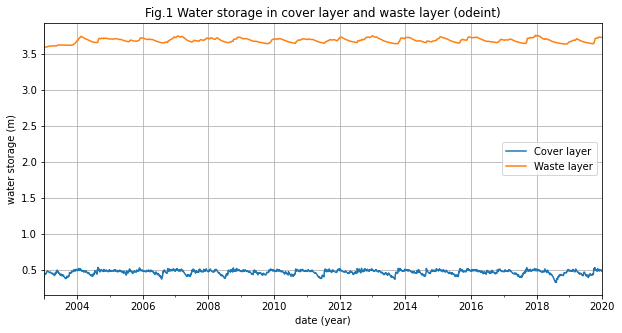

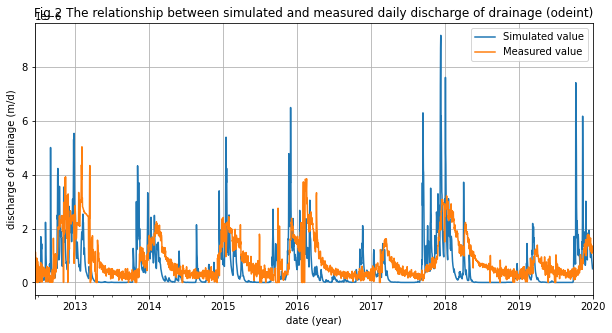

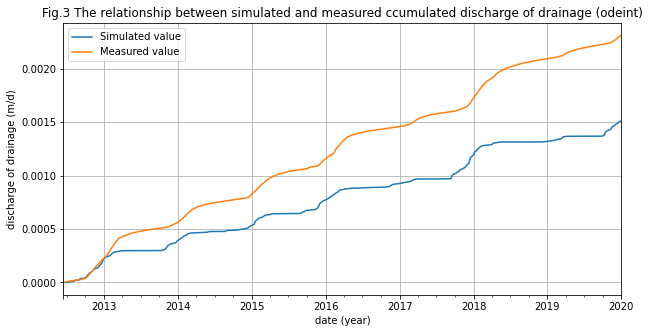

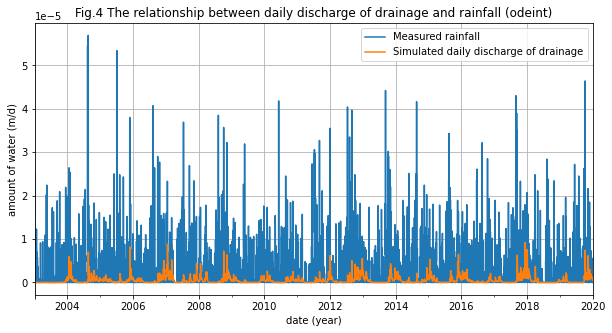

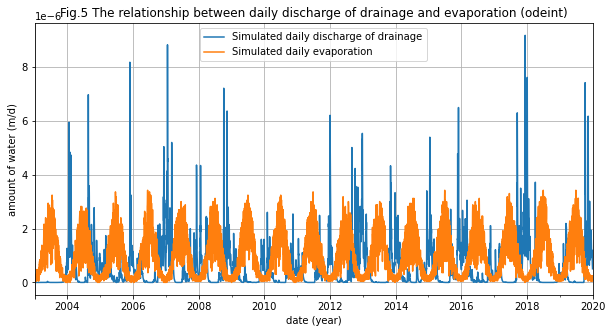

<Figure size 432x288 with 0 Axes>

In [2]:
# odeint

tic()

# Solution using built in solver (odeint)
t_span = [tOut[0], tOut[-1]]
yode = solve_ivp(dydt, t_span, y0, t_eval=tOut, vectorized=True, method='RK45', rtol=1e-5)
data['Scl_ode'] = yode.y[0, :]
data['Swb_ode'] = yode.y[1, :]
data['Qdr_ode'] = Qdr(data.Scl_ode, data.Swb_ode)
data['Qdraccu_ode'] = data.dropna(axis=0).Qdr_ode.cumsum()
for t in range (len(J)):
    data['f'] = (yode.y[0, :][t]<pEv.min()) * 0 + (pEv.min()<=yode.y[0, :][t]<=pEv.max()) * (yode.y[0, :][t] - pEv.min())/(pEv.max() - pEv.min()) + (pEv.max()<yode.y[0, :][t])
    data['E_ode'] = data.pEV * Cf * data.f / 1000

toc()

# Plot FIG.1 Water storage in cover layer and waste layer (odeint)
data.Scl_ode.plot(figsize=[10, 5], label='Cover layer')
data.Swb_ode.plot(label='Waste layer')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('water storage (m)')
plt.title('Fig.1 Water storage in cover layer and waste layer (odeint)')
plt.figure()

# Plot FIG.2 The relationship between simulated and measured daily discharge of drainage (odeint)
data.Qdr_ode.plot(figsize=[10, 5], label='Simulated value')
data.Q.plot(label='Measured value')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('discharge of drainage (m/d)')
plt.xlim('2012/6/14', '2020')
plt.title('Fig.2 The relationship between simulated and measured daily discharge of drainage (odeint)')
plt.figure()

# Plot FIG.3 The relationship between simulated and measured ccumulated discharge of drainage (odeint)
data.Qdraccu_ode.plot(figsize=[10, 5], label='Simulated value')
data.Qaccu.plot(label='Measured value')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('discharge of drainage (m/d)')
plt.xlim('2012/6/14', '2020')
plt.title('Fig.3 The relationship between simulated and measured ccumulated discharge of drainage (odeint)')
plt.figure()

# Plot FIG.4 The relationship between daily discharge of drainage and rainfall (odeint)
data.J.plot(label='Measured rainfall')
data.Qdr_ode.plot(figsize=[10, 5], label='Simulated daily discharge of drainage')

plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('amount of water (m/d)')
plt.title('Fig.4 The relationship between daily discharge of drainage and rainfall (odeint)')
plt.figure()

# Plot FIG.5 The relationship between daily discharge of drainage and evaporation (odeint)
data.Qdr_ode.plot(figsize=[10, 5], label='Simulated daily discharge of drainage')
data.E_ode.plot(label='Simulated daily evaporation')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('amount of water (m/d)')
plt.title('Fig.5 The relationship between daily discharge of drainage and evaporation (odeint)')
plt.figure()

## Solution using my own implementation based on Euler's approach

Eulers method is the most simple approach for numerically solving an ordinary differential equation. In order to guarantee a stable solution we need to ensure that the time step is not too large. We need to program an approach to control the time step size based on the calculated rates. In this case we want to have a maximum decrease in  states to be 70 % of the current value. 

Because we need to store output at the required output times we need to initialize an output vector. The time stepping needs to be initialized as well. The size of the time step is also controlled by the out put times, we need to make sure that the model calculates the states for all predefined output times.

In [3]:
'''

# Euler's approach

yEuler = np.zeros([nOut, 2], dtype=float)

dtmax = 0.05       # max time step
t = tOut[0]       # initial time
iiOut = 0

y = y0

tic()

yEuler[iiOut] = y
while (t<tOut[nOut-1]):
    # check time steps
    np.seterr(divide='ignore', invalid='ignore')
    rate = dYdt(t, y)
    dtrate = -0.07 * y / rate                            
    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1] - t
    dt = min(min(dtrate), dtmax, dtOut)
    # Update states
    y += rate * dt
    t += dt
    #Update output matrix
    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        yEuler[iiOut+1] = y
        iiOut += 1
data['Scl_Euler'], data['Swb_Euler'] = yEuler.T
data['Qdr_Euler'] = Qdr(data.Scl_Euler, data.Swb_Euler)

toc()

# Plot FIG. Water storage in cover layer and waste layer (Euler's approach)
data.Scl_Euler.plot(figsize=[8, 6], label='Cover layer')
data.Swb_Euler.plot(label='Waste layer')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('water storage (m)')
plt.title('Fig. Water storage in cover layer and waste layer (Euler's approach)')
plt.figure()

# Plot FIG. The relationship between simulated and measured ccumulated discharge of drainage (Euler's approach)
data.Qdr_Euler.plot(figsize=[8, 6], label='Simulated value')
data.Q.plot(label='Measured value')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('discharge of drainage (m/d)')
plt.xlim('2012', '2020')
plt.title('Fig. The relationship between simulated and measured daily discharge of drainage (Euler's approach)')
plt.figure()

'''

"\n\n# Euler's approach\n\nyEuler = np.zeros([nOut, 2], dtype=float)\n\ndtmax = 0.05       # max time step\nt = tOut[0]       # initial time\niiOut = 0\n\ny = y0\n\ntic()\n\nyEuler[iiOut] = y\nwhile (t<tOut[nOut-1]):\n    # check time steps\n    np.seterr(divide='ignore', invalid='ignore')\n    rate = dYdt(t, y)\n    dtrate = -0.07 * y / rate                            \n    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account\n    dtOut = tOut[iiOut+1] - t\n    dt = min(min(dtrate), dtmax, dtOut)\n    # Update states\n    y += rate * dt\n    t += dt\n    #Update output matrix\n    if (np.abs(tOut[iiOut+1]-t)<1e-5) :\n        yEuler[iiOut+1] = y\n        iiOut += 1\ndata['Scl_Euler'], data['Swb_Euler'] = yEuler.T\ndata['Qdr_Euler'] = Qdr(data.Scl_Euler, data.Swb_Euler)\n\ntoc()\n\n# Plot FIG. Water storage in cover layer and waste layer (Euler's approach)\ndata.Scl_Euler.plot(figsize=[8, 6], label='Cover layer')\ndata.Swb_Euler.pl

Clearly this solution is unstable, as time progresses you will see that the solution eventually becomes unstable, even with the stability criterium. The time step has to be much smaller for a stable (first-order) approximation. You can improve the accuracy of the solution by reducing dtMax.

## Other easy to implement solutions (predictor-corrector and Runge-Kutta 4th order)

Following the template used for the Euler method we can easily expand the approach to predictor-corrector and the Runge Kutta fourth order approaches. These are more accurate that the Euler and with a similar time step criterion lead to much better solutions. This is because these solutions have higher order accuracies (2nd and 4th).

In [4]:
'''

# EULER Predictor Corrector

yPC = np.zeros([nOut, 2], dtype=float)

dtmax = 0.1       # max time step
t = tOut[0]       # initial time
iiOut = 0

y = y0

tic()

yPC[iiOut] = y
while (t<tOut[nOut-1]):
    # check time steps
    np.seterr(divide='ignore', invalid='ignore')
    rate = dydt(t, y)
    dtrate = -0.07 * y / rate
    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1] - t
    dt = min(min(dtrate), dtmax, dtOut)    
    # Iteration with predictor corrector
    converged = False
    convCrit = 1e-6;
    y1 = y + rate * dt
    while not(converged):
        rate1 = dydt(t, y1)
        y2 = y + (rate + rate1) / 2 * dt
        if max(np.abs(y1-y2))<convCrit:
            converged = True
        else:
            y1 = y2
    # Update states
    y = y1
    t += dt
    #Update output matrix
    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        yPC[iiOut+1] = y
        iiOut += 1
data['Scl_PC'], data['Swb_PC'] = yPC.T
data['Qdr_PC'] = Qdr(data.Scl_PC, data.Swb_PC)

toc()

# Plot FIG. Water storage in cover layer and waste layer (Predictor-corrector approach)
data.Scl_PC.plot(figsize=[8, 6], label='Cover layer')
data.Swb_PC.plot(label='Waste layer')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('water storage (m)')
plt.title('Fig. Water storage in cover layer and waste layer (Predictor-corrector approach)')
plt.figure()

# Plot FIG. The relationship between simulated and measured ccumulated discharge of drainage (Predictor-corrector approach)
data.Qdr_PC.plot(figsize=[8, 6], label='Simulated value')
data.Q.plot(label='Measured value')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('discharge of drainage (m/d)')
plt.xlim('2012', '2020')
plt.title('Fig. The relationship between simulated and measured daily discharge of drainage (Predictor-corrector approach)')
plt.figure()

'''

"\n\n# EULER Predictor Corrector\n\nyPC = np.zeros([nOut, 2], dtype=float)\n\ndtmax = 0.1       # max time step\nt = tOut[0]       # initial time\niiOut = 0\n\ny = y0\n\ntic()\n\nyPC[iiOut] = y\nwhile (t<tOut[nOut-1]):\n    # check time steps\n    np.seterr(divide='ignore', invalid='ignore')\n    rate = dydt(t, y)\n    dtrate = -0.07 * y / rate\n    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account\n    dtOut = tOut[iiOut+1] - t\n    dt = min(min(dtrate), dtmax, dtOut)    \n    # Iteration with predictor corrector\n    converged = False\n    convCrit = 1e-6;\n    y1 = y + rate * dt\n    while not(converged):\n        rate1 = dydt(t, y1)\n        y2 = y + (rate + rate1) / 2 * dt\n        if max(np.abs(y1-y2))<convCrit:\n            converged = True\n        else:\n            y1 = y2\n    # Update states\n    y = y1\n    t += dt\n    #Update output matrix\n    if (np.abs(tOut[iiOut+1]-t)<1e-5) :\n        yPC[iiOut+1] = y\n      

## Other easy to implement solutions (Runge-Kutta 4th order)

In [5]:
'''

# RungeKutta

yRK = np.zeros([nOut, 2], dtype=float)

dtmax = 0.1       # max time step
t = tOut[0]       # initial time
iiOut = 0

y = y0

tic()

yRK[iiOut] = y
while (t<tOut[nOut-1]):
    # check time steps
    np.seterr(divide='ignore', invalid='ignore')
    rate = dydt(t, y)
    dtrate = -0.07 * y / rate
    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1] - t
    dt = min(min(dtrate), dtmax, dtOut)    
    # Iteration with Runge-Kutta 4th order
    k1 = dt * dydt(t, y)
    k2 = dt * dydt(t+dt/2, y+k1/2)
    k3 = dt * dydt(t+dt/2, y+k2/2)
    k4 = dt * dydt(t+dt, y+k3)
    # Update states
    y += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    t += dt
    #Update output matrix
    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        yRK[iiOut+1] = y
        iiOut += 1
data['Scl_RK'], data['Swb_RK'] = yRK.T
data['Qdr_RK'] = Qdr(data.Scl_RK, data.Swb_RK)

toc()

# Plot FIG. Water storage in cover layer and waste layer (Runge-Kutta 4th order)
data.Scl_RK.plot(figsize=[8, 6], label='Cover layer')
data.Swb_RK.plot(label='Waste layer')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('water storage (m)')
plt.title('Fig. Water storage in cover layer and waste layer (Runge-Kutta 4th order)')
plt.figure()

# Plot FIG. The relationship between simulated and measured ccumulated discharge of drainage (Runge-Kutta 4th order)
data.Qdr_RK.plot(figsize=[8, 6], label='Simulated value')
data.Q.plot(label='Measured value')
plt.grid()
plt.legend(loc='best')
plt.xlabel('date (year)')
plt.ylabel('discharge of drainage (m/d)')
plt.xlim('2012', '2020')
plt.title('Fig. The relationship between simulated and measured daily discharge of drainage (Runge-Kutta 4th order)')
plt.figure()

'''

"\n\n# RungeKutta\n\nyRK = np.zeros([nOut, 2], dtype=float)\n\ndtmax = 0.1       # max time step\nt = tOut[0]       # initial time\niiOut = 0\n\ny = y0\n\ntic()\n\nyRK[iiOut] = y\nwhile (t<tOut[nOut-1]):\n    # check time steps\n    np.seterr(divide='ignore', invalid='ignore')\n    rate = dydt(t, y)\n    dtrate = -0.07 * y / rate\n    dtrate = (dtrate<0) * dtmax + (dtrate>=0) * dtrate   # We only need to take the positive rates in to account\n    dtOut = tOut[iiOut+1] - t\n    dt = min(min(dtrate), dtmax, dtOut)    \n    # Iteration with Runge-Kutta 4th order\n    k1 = dt * dydt(t, y)\n    k2 = dt * dydt(t+dt/2, y+k1/2)\n    k3 = dt * dydt(t+dt/2, y+k2/2)\n    k4 = dt * dydt(t+dt, y+k3)\n    # Update states\n    y += (k1 + 2 * k2 + 2 * k3 + k4) / 6\n    t += dt\n    #Update output matrix\n    if (np.abs(tOut[iiOut+1]-t)<1e-5) :\n        yRK[iiOut+1] = y\n        iiOut += 1\ndata['Scl_RK'], data['Swb_RK'] = yRK.T\ndata['Qdr_RK'] = Qdr(data.Scl_RK, data.Swb_RK)\n\ntoc()\n\n# Plot FIG. Wa